# This file is the same as the elec_RandomForest except the hyperparameters input to the RandomForestRegression model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from  scipy.stats import skew, kurtosis, shapiro

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dmd = pd.read_csv('VIC2014-2021.csv')

In [5]:
dmd

,Datetime,Demand,Price
0,2014/1/1 0:30,4656.030000,44.040000
1,2014/1/1 1:00,4373.040000,41.440000
2,2014/1/1 1:30,4175.320000,37.100000
3,2014/1/1 2:00,4003.350000,33.790000
4,2014/1/1 2:30,3841.740000,20.410000
...,...,...,...
140249,2021/12/31 21:30,5657.276667,87.200000
140250,2021/12/31 22:00,5407.026667,123.723333
140251,2021/12/31 22:30,5291.213333,120.326667
140252,2021/12/31 23:00,5314.540000,109.208333


In [6]:
dmd['Datetime'] = pd.to_datetime(dmd['Datetime'],format='%Y-%m-%d %H:%M')

In [7]:
dmd.sort_values(by='Datetime',inplace=True)
dmd.set_index('Datetime',inplace=True)

In [8]:
dmd

,Demand,Price
Datetime,,
2014-01-01 00:30:00,4656.030000,44.040000
2014-01-01 01:00:00,4373.040000,41.440000
2014-01-01 01:30:00,4175.320000,37.100000
2014-01-01 02:00:00,4003.350000,33.790000
2014-01-01 02:30:00,3841.740000,20.410000
...,...,...
2021-12-31 21:30:00,5657.276667,87.200000
2021-12-31 22:00:00,5407.026667,123.723333
2021-12-31 22:30:00,5291.213333,120.326667


In [9]:
dmd1 = dmd.resample('D').mean()

In [10]:
dmd2 = dmd.resample('D').sum()

In [11]:
dmd1['Demand']= dmd2['Demand']

In [12]:
dmd1

,Demand,Price
Datetime,,
2014-01-01,201465.190000,36.769149
2014-01-02,230442.770000,43.859375
2014-01-03,226672.910000,44.148333
2014-01-04,208400.340000,42.769583
2014-01-05,202206.160000,40.518333
...,...,...
2021-12-27,156773.616666,-23.518194
2021-12-28,160029.526664,-3.293576
2021-12-29,184253.431671,26.780000


In [13]:
dmd1["year"] = dmd1.index.year
dmd1["mon"] = dmd1.index.month
dmd1["week"] = dmd1.index.week
dmd1["day"] = dmd1.index.weekday
dmd1["ix"] = range(0,len(dmd1))

Text(0.5, 1.0, 'Demand distribution')

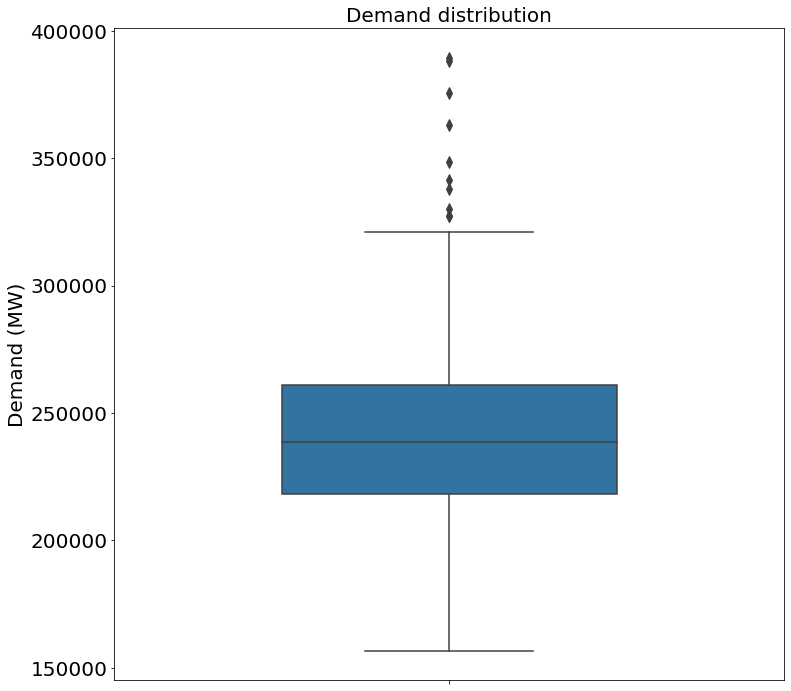

In [14]:
plt.figure(figsize=(12,12))
plt.yticks(fontsize=20)
sns.boxplot(dmd1['Demand'],orient="v",width=0.5,fliersize=8)
plt.ylabel('Demand (MW)',fontsize=20)
plt.title('Demand distribution',fontsize=20)

Text(0.5, 1.0, 'Price distribution')

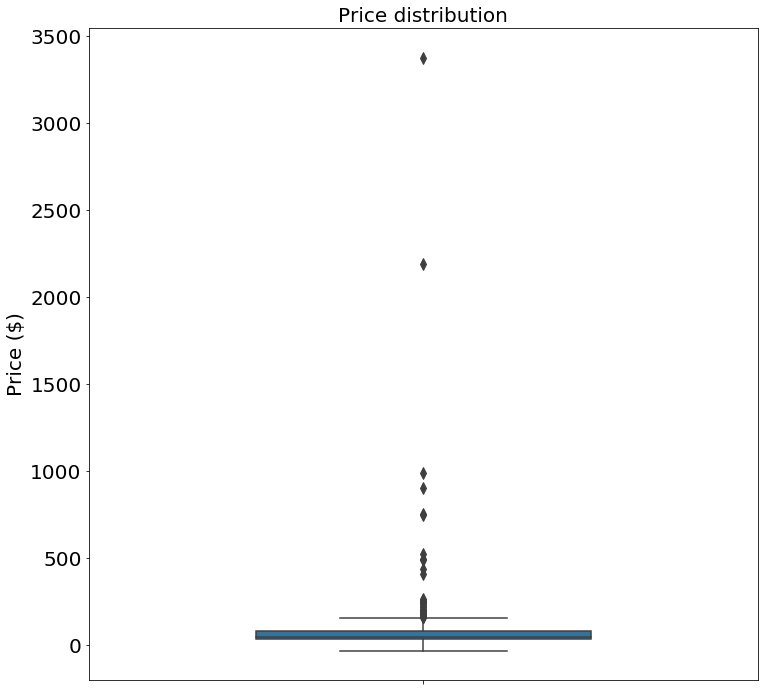

In [15]:
plt.figure(figsize=(12,12))
plt.yticks(fontsize=20)
sns.boxplot(dmd1['Price'],orient="v",width=0.5,fliersize=8)
plt.ylabel('Price ($)',fontsize=20)
plt.title('Price distribution',fontsize=20)

# Normality

In [16]:
mean = np.mean(dmd1.Demand.values)
std = np.std(dmd1.Demand.values)
skew = skew(dmd1.Demand.values)
ex_kurt = kurtosis(dmd1.Demand)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.2737066983387573 
Kurtosis: 3.257092524179736


In [17]:
def shapiro_test(data, alpha=0.01):
    stat, p_value = shapiro(data)
    print("H0: Data was drawn from a Normal Ditribution")
    if (p_value<alpha):
        print("p-value {} is lower than significance level: {}, therefore null hypothesis is rejected".format(p_value, alpha))
    else:
        print("p-value {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(p_value, alpha))
        
shapiro_test(dmd1.Demand, alpha=0.01)

H0: Data was drawn from a Normal Ditribution
p-value 1.3868956981119562e-12 is lower than significance level: 0.01, therefore null hypothesis is rejected


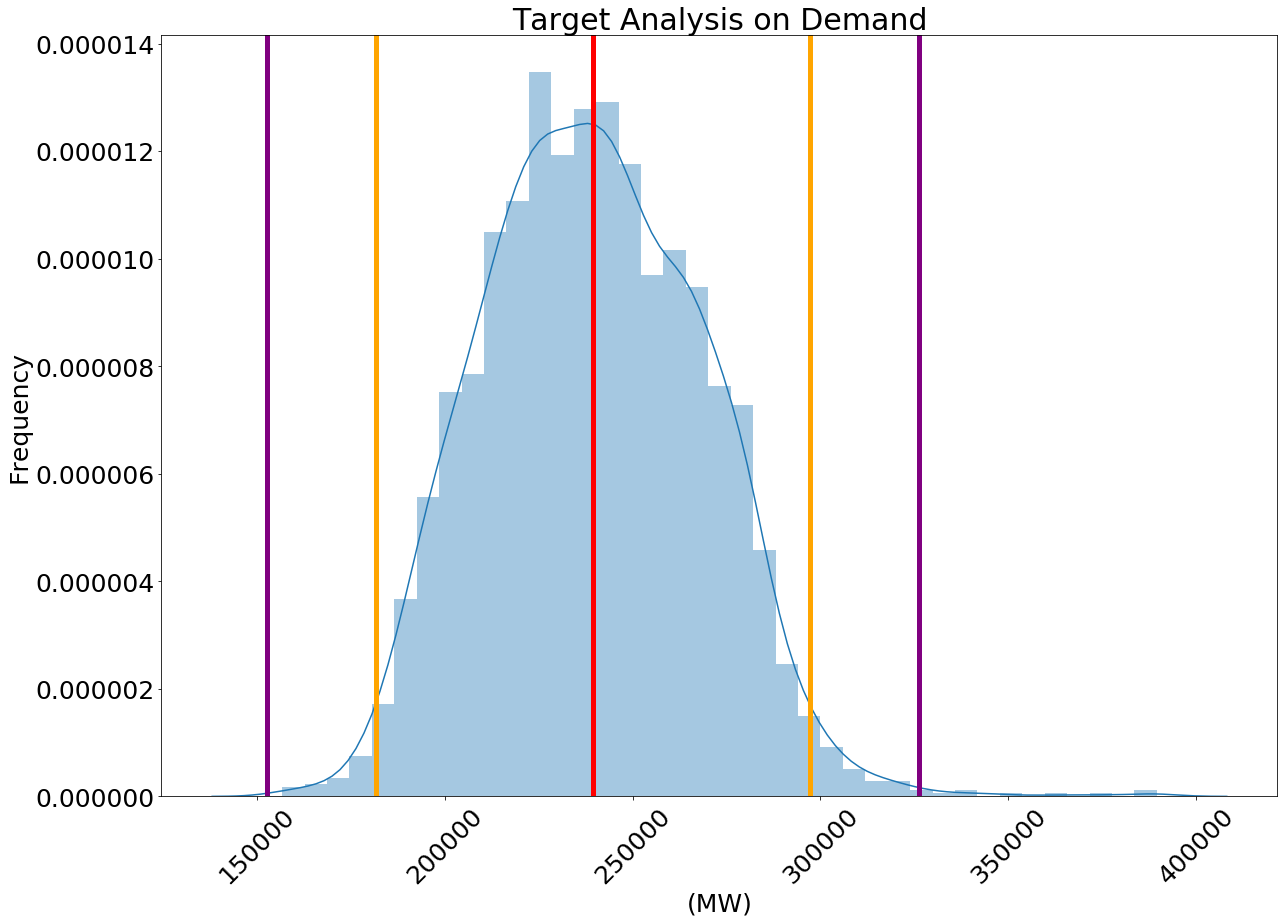

In [18]:
plt.figure(figsize=(20,14))
sns.distplot(dmd1.Demand)
plt.title("Target Analysis on Demand",fontsize=30)
plt.xticks(rotation=45,fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("(MW)",fontsize=25)
plt.ylabel("Frequency",fontsize=25)
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean),linewidth=5)
plt.axvline(x=mean+2*std, color='orange', linestyle='-',linewidth=5)
plt.axvline(x=mean-2*std, color='orange', linestyle='-',linewidth=5)
plt.axvline(x=mean+3*std, color='purple', linestyle='-',linewidth=5)
plt.axvline(x=mean-3*std, color='purple', linestyle='-',linewidth=5)
plt.show()

In [19]:
dmd_mon = dmd1.resample('M').sum()
dmd = pd.read_csv('VIC2014-2021.csv')

In [20]:
dmd_mon

,Demand,Price,year,mon,week,day,ix
Datetime,,,,,,,
2014-01-31,8.412518e+06,2244.980191,62434,31,93,93,465
2014-02-28,7.647694e+06,1379.110000,56392,56,202,84,1246
2014-03-31,7.925168e+06,1424.700417,62434,93,354,95,2294
2014-04-30,7.454656e+06,1313.448333,60420,120,474,87,3135
2014-05-31,8.097877e+06,1494.512292,62434,155,624,96,4185
...,...,...,...,...,...,...,...
2021-08-31,7.478668e+06,1457.381667,62651,248,1010,91,86304
2021-09-30,6.536996e+06,832.654792,60630,270,1108,89,84435
2021-10-31,6.457018e+06,572.051250,62651,310,1279,99,88195


In [21]:
dmd_mon['ix'] = range(0,len(dmd_mon))

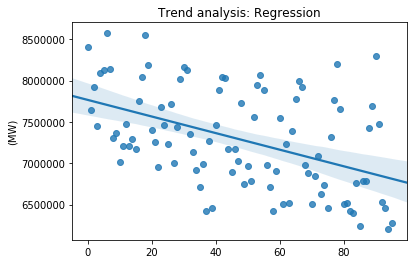

In [22]:
sns.regplot(data=dmd_mon,x='ix', y="Demand")
plt.title("Trend analysis: Regression")
plt.ylabel("(MW)")
plt.xlabel("")
plt.show()

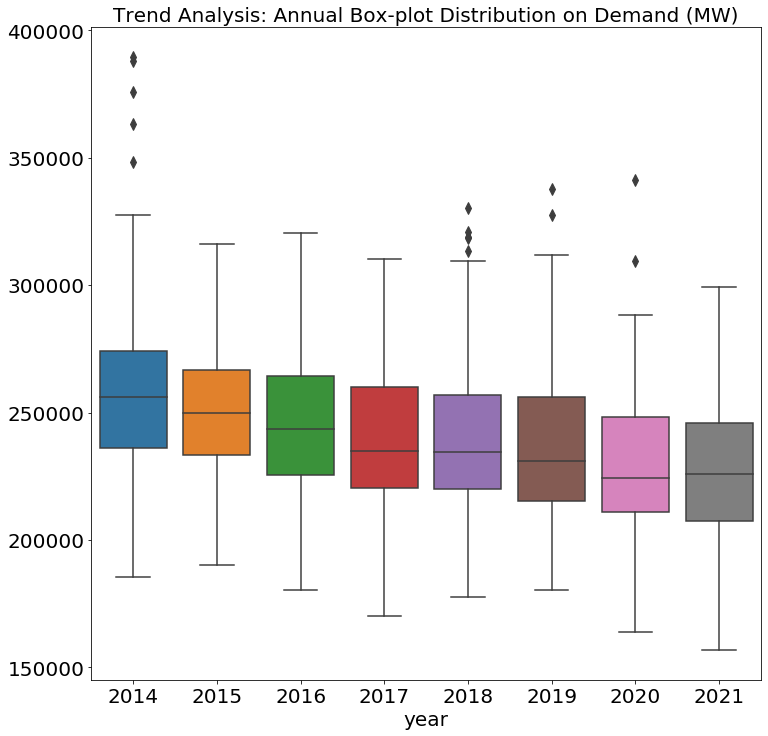

In [23]:
plt.figure(figsize=(12,12))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('year',fontsize=20)
sns.boxplot(data=dmd1["2014":"2021"], x="year", y="Demand",fliersize=8)
plt.ylabel('')
plt.title("Trend Analysis: Annual Box-plot Distribution on Demand (MW)",fontsize=20)
plt.show()

# Feature Engineering

In [24]:
dmd1

,Demand,Price,year,mon,week,day,ix
Datetime,,,,,,,
2014-01-01,201465.190000,36.769149,2014,1,1,2,0
2014-01-02,230442.770000,43.859375,2014,1,1,3,1
2014-01-03,226672.910000,44.148333,2014,1,1,4,2
2014-01-04,208400.340000,42.769583,2014,1,1,5,3
2014-01-05,202206.160000,40.518333,2014,1,1,6,4
...,...,...,...,...,...,...,...
2021-12-27,156773.616666,-23.518194,2021,12,52,0,2917
2021-12-28,160029.526664,-3.293576,2021,12,52,1,2918
2021-12-29,184253.431671,26.780000,2021,12,52,2,2919


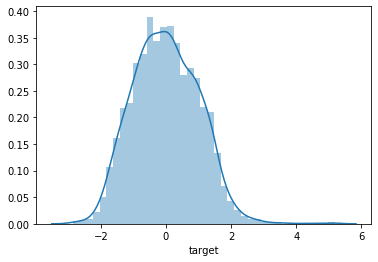

In [25]:
dmd1["target"] = dmd1.Demand.add(-mean).div(std)
sns.distplot(dmd1["target"])
plt.show()

In [26]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    dmd1["target_t" + str(t)] = dmd1.target.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,31):
    dmd1["feat_ar" + str(t)] = dmd1.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    dmd1[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = dmd1.Demand.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(dmd1.mon,
                              prefix="mon",
                              drop_first=True)
months.index = dmd1.index
dmd1 = pd.concat([dmd1, months], axis=1)

days = pd.get_dummies(dmd1.day,
                              prefix="day",
                              drop_first=True)
days.index = dmd1.index
dmd1 = pd.concat([dmd1, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

In [27]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

In [28]:
dmd1[["movave_7", "movstd_7"]] = dmd1.Demand.rolling(7).agg([np.mean, np.std])
dmd1[["movave_30", "movstd_30"]] = dmd1.Demand.rolling(30).agg([np.mean, np.std])

In [29]:
corr = dmd1[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]

<Figure size 1440x1440 with 0 Axes>

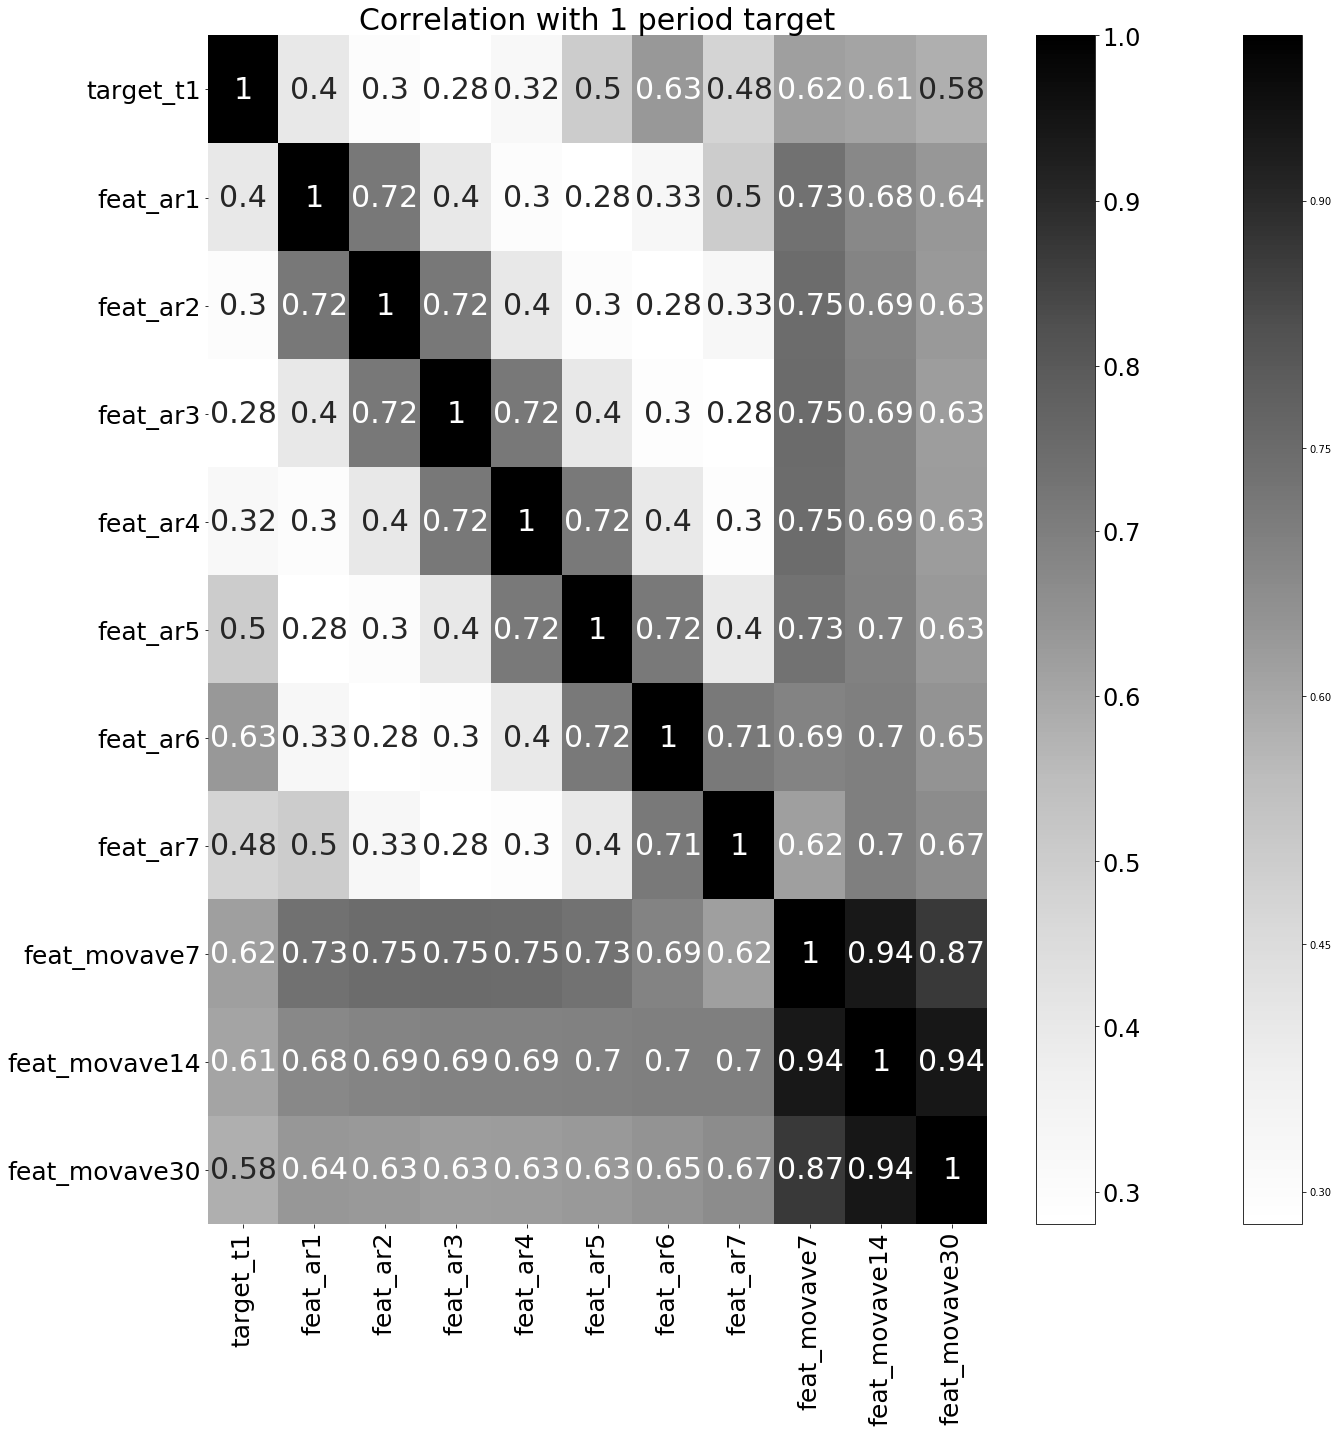

In [30]:
# Plot heatmap of correlation matrix

plt.figure(figsize=(20,20))
f,ax = plt.subplots(figsize = (20,20))
h = sns.heatmap(corr, annot=True,cmap='Greys',annot_kws={'size':30})
bottom, top = ax.get_ylim()
h.set_ylim(bottom + 0.5, top - 0.5)
cb=h.figure.colorbar(h.collections[0])
cb.ax.tick_params(labelsize=24)
plt.title("Correlation with 1 period target",fontsize=30)
plt.yticks(rotation=0,fontsize=25,); plt.xticks(rotation=90,fontsize=25)  # fix ticklabel directions
plt.tight_layout()
plt.show()  # show the plot

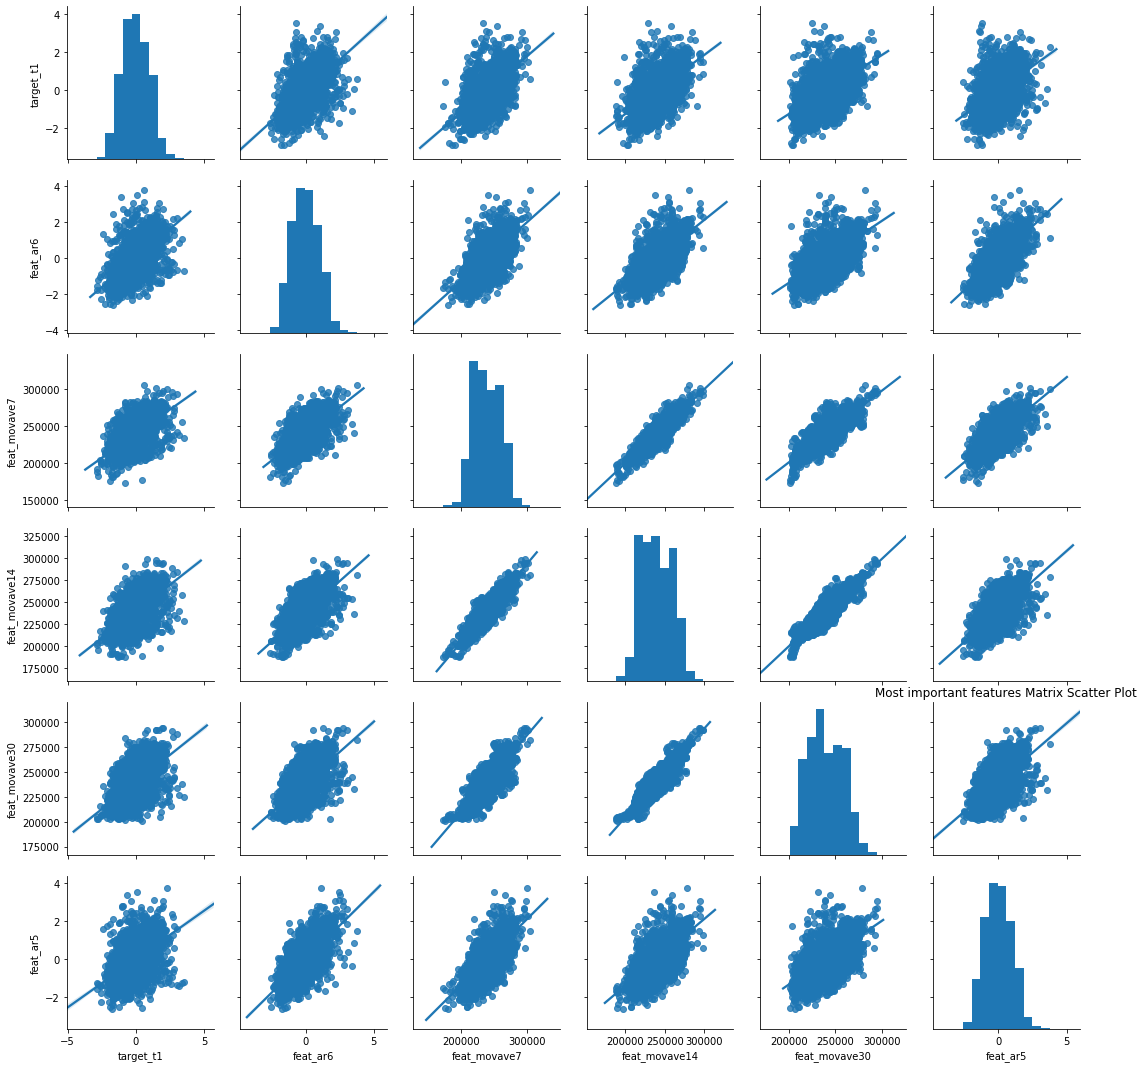

In [31]:
sns.pairplot(data=dmd1[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

# model build

In [32]:
data_feateng = dmd1[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

Number of observations:  2862


Total number of observations:  2862
Train: (2527, 59)(2527, 30), 
Test: (335, 59)(335, 30)


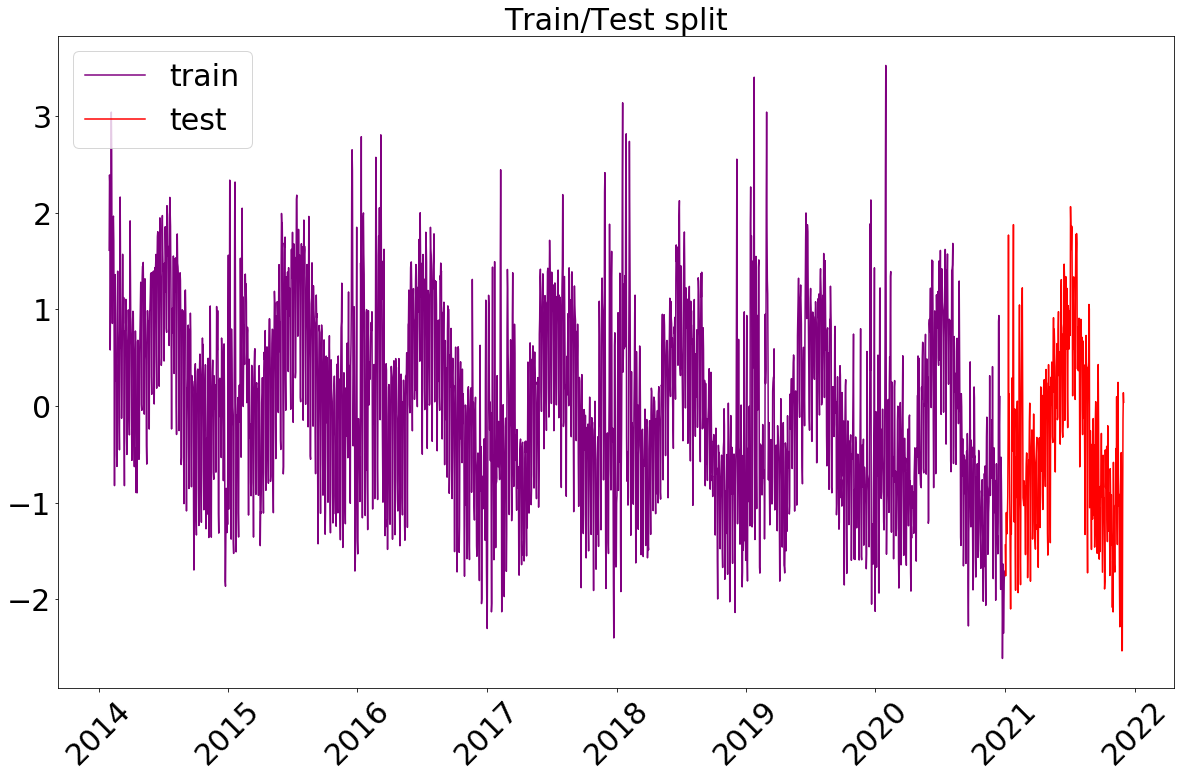

In [33]:
X_train = data_feateng.loc["2014":"2020"][features]
y_train = data_feateng.loc["2014":"2020"][targets]

X_test = data_feateng.loc["2021"][features]
y_test = data_feateng.loc["2021"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.figure(figsize=(20,12))
plt.plot(y_train.index, y_train.target_t1.values, label="train",color='purple')
plt.plot(y_test.index, y_test.target_t1.values, label="test",color='red')
plt.title("Train/Test split",fontsize=30)
plt.xticks(rotation=45,fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc='upper left',fontsize=30)
plt.show()

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 0.4592245483570332
Test RMSE: 0.4639768863482391


# Input several parameters and use it to build the regression model, evaluate performance by calculating MAPE

TRAIN: 634 TEST: 631


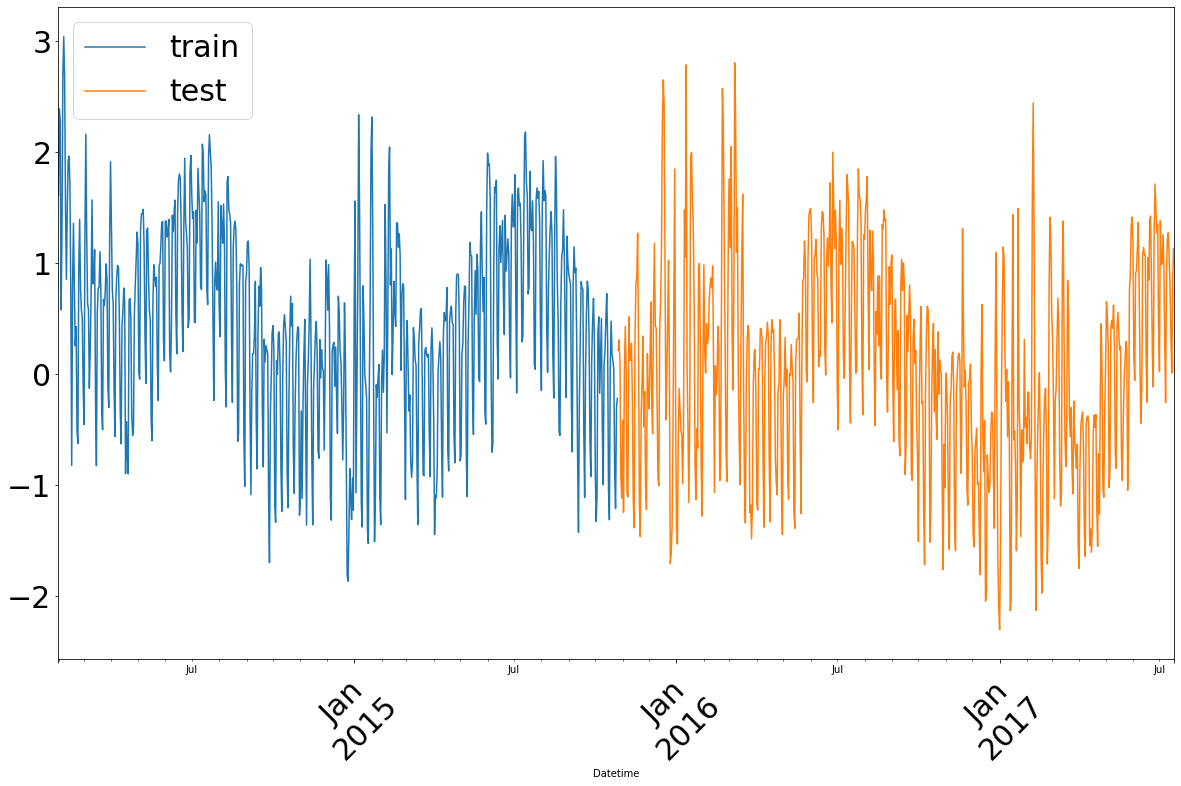

TRAIN: 730 TEST: 631


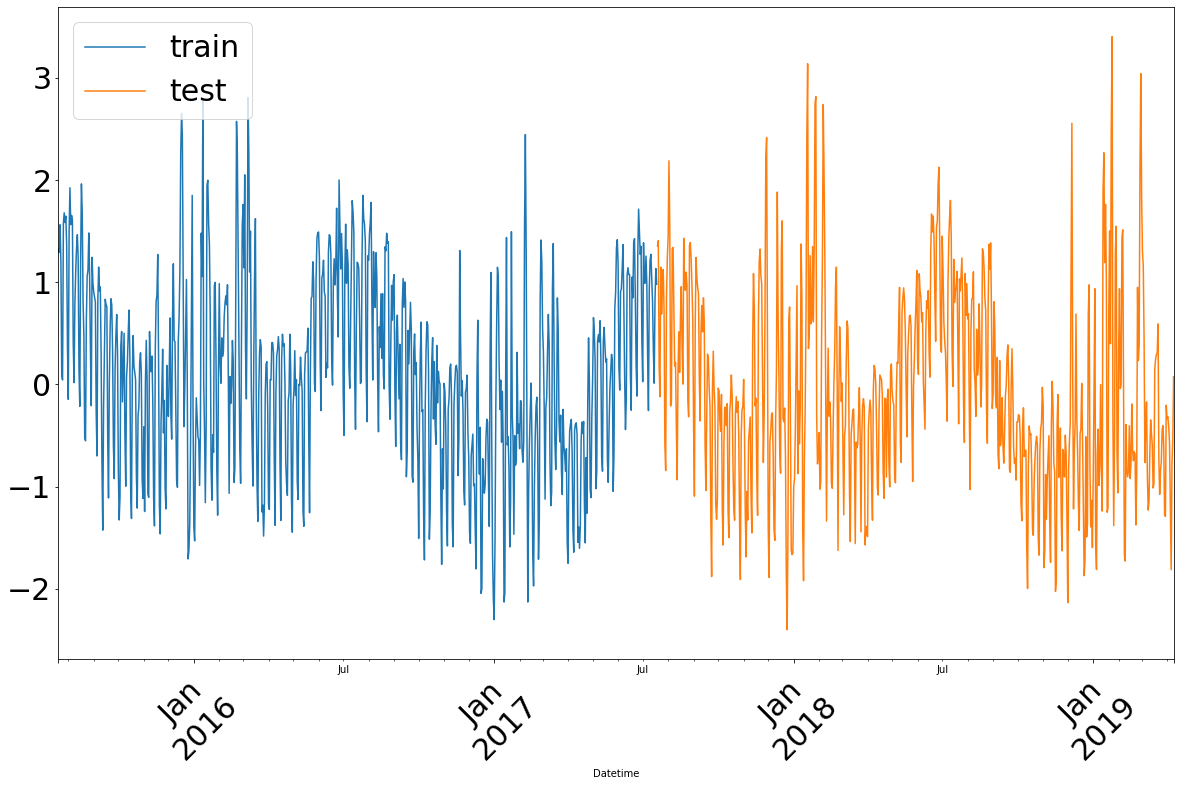

TRAIN: 730 TEST: 631


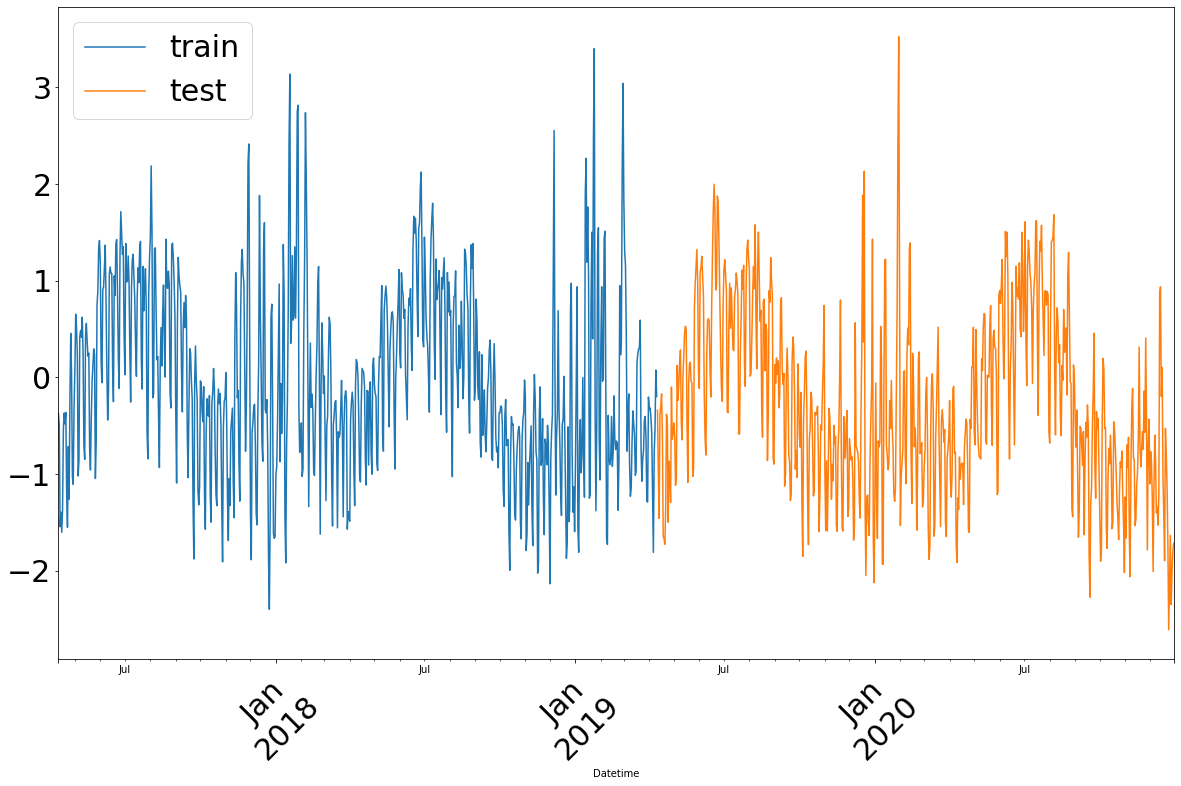

In [35]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    plt.figure(figsize=(20,12))
    y_train["target_t1"][train_index].plot(label='train')
    y_train["target_t1"][val_index].plot(label='test')
    plt.xticks(rotation=45,fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='upper left',fontsize=30)
    plt.show()

In [36]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [3, 5, 10, 20, 30], 
        'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 10}
Best-Fold Train RMSE:  0.04465342353640652
Best-Fold Val RMSE:  0.4604767469406823


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 8, 'max_depth': 30}
Best-Fold Train RMSE:  0.04558731506210496
Best-Fold Val RMSE:  0.5012099538681992


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 59, 'max_depth': 30}
Best-Fold Train RMSE:  0.056383790034738146
Best-Fold Val RMSE:  0.3597005401125479




In [37]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2014":"2020"], y_train.loc["2014":"2020", "target_t1"])

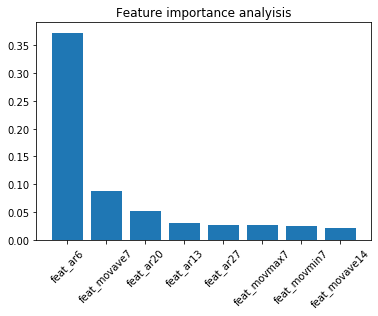

In [38]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:8]
x = range(len(sorted_index_top))
# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()


In [39]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

In [40]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = np.abs(test_df["resid_t1"].div(test_df["target_t1"]))

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  5.647985870965056


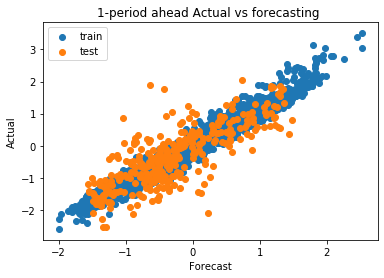

In [41]:
plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()

<Figure size 1440x864 with 0 Axes>

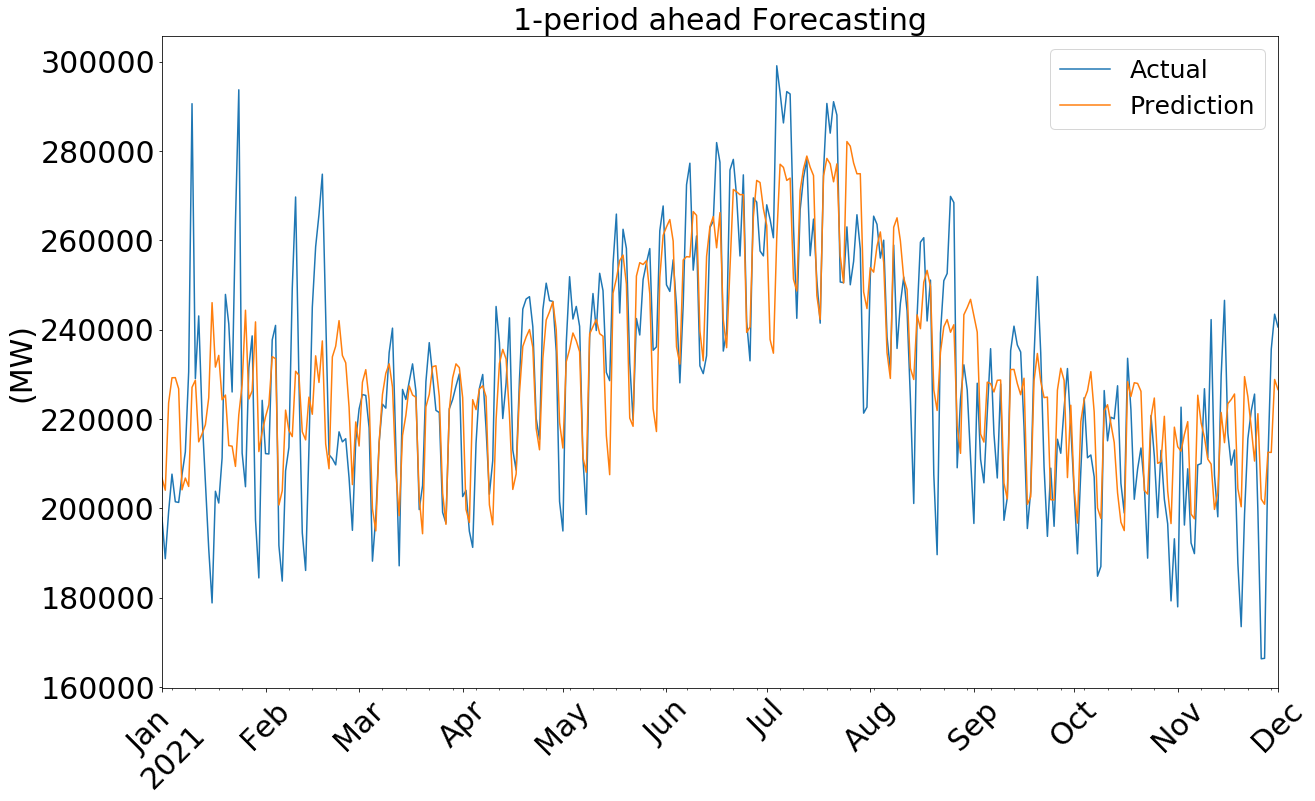

In [42]:
plt.figure(figsize=(20,12))
test_df[["target_t1", "pred_t1"]].plot(figsize=(20,12))
label=['Actual','Prediction']
plt.title("1-period ahead Forecasting",fontsize=30)
plt.xticks(rotation=45,fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("(MW)",fontsize=30)
plt.xlabel('')
plt.legend(label,fontsize=25)
plt.show()